In [1]:
#Install pybind11
!git clone https://github.com/pybind/pybind11.git
!cd pybind11 && mkdir build && cd build && cmake .. && make install

Cloning into 'pybind11'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 13933 (delta 10), reused 12 (delta 1), pack-reused 13897
Receiving objects: 100% (13933/13933), 5.45 MiB | 25.39 MiB/s, done.
Resolving deltas: 100% (9471/9471), done.
-- The CXX compiler identification is GNU 7.5.0
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- pybind11 v2.6.2 dev1
-- CMake 3.12.0
-- Found PythonInterp: /usr/bin/python3.6 (found version "3.6.9") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.6m.so
-- PYTHON 3.6.9
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- pybind11::lto enabled
-- pybind11::thin_lto enabled
-- Setting tests build type to MinSizeRel as

In [2]:
#Install Eigen
!apt install libeigen3-dev
!ln -sf /usr/include/eigen3/Eigen /usr/include/Eigen

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libeigen3-doc libmrpt-dev
The following NEW packages will be installed:
  libeigen3-dev
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 810 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libeigen3-dev all 3.3.4-4 [810 kB]
Fetched 810 kB in 1s (677 kB/s)
Selecting previously unselected package libeigen3-dev.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../libeigen3-dev_3.3.4-4_all.deb ...
Unpacking libeigen3-dev (3.3.4-4) ...
Setting up libeigen3-dev (3.3.4-4) ...


In [3]:
# Install dependencies on colab
!git clone https://github.com/OttoJursch/DRL_robot_exploration.git

Cloning into 'DRL_robot_exploration'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 11174 (delta 77), reused 59 (delta 29), pack-reused 11049
Receiving objects: 100% (11174/11174), 284.84 MiB | 37.02 MiB/s, done.
Resolving deltas: 100% (170/170), done.
Checking out files: 100% (10919/10919), done.


In [4]:
!#Build the C++/pybind stuff
!rm -rf DRL_robot_exploration/build
!cd DRL_robot_exploration && mkdir build && cd build && cmake .. && make

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found PythonInterp: /usr/bin/python3 (found version "3.6.9") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.6m.so
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- Found pybind11: /usr/local/include (found version "2.6.2" dev1)
-- Configuring done
-- Generating done
-- Build files have been written to: /content/DRL_robot_exploration/build
Scanning dependencies of target

In [5]:
!cd DRL_robot_exploration && git pull

Already up to date.


In [6]:
from copy import deepcopy

class PaperRewardFunction:
    '''
    Reward function from the paper
    '''
    def __init__(self):
        pass

    def get_reward(self, robot_position, old_op_map, op_map, coll_index):
        '''
        Takes in map before step and map after step. Measures effect of sensor
        input from last step
        '''
        if not coll_index:
            reward = float(
                np.size(np.where(op_map == 255)) -
                np.size(np.where(old_op_map == 255))) / 14000
            if reward > 1:
                reward = 1
        else:
            reward = -1
        return reward


class FrontierRewardFunction:
    def __init__(self, reward_scale):
        self.reward_scale = reward_scale
        self.paper_reward = PaperRewardFunction()

    def frontiers(self, op_map, map_size, points):
        y_len = map_size[0]
        x_len = map_size[1]
        mapping = op_map.copy()
        # 0-1 unknown area map
        mapping = (mapping == 127) * 1
        mapping = np.lib.pad(mapping, ((1, 1), (1, 1)),
                             'constant',
                             constant_values=0)
        fro_map = mapping[2:][:, 1:x_len + 1] + mapping[:y_len][:, 1:x_len + 1] + mapping[1:y_len + 1][:, 2:] + \
                  mapping[1:y_len + 1][:, :x_len] + mapping[:y_len][:, 2:] + mapping[2:][:, :x_len] + mapping[2:][:,
                                                                                                      2:] + \
                  mapping[:y_len][:, :x_len]

        ind_free = np.where(op_map.ravel(order='F') == 255)[0]
        ind_fron_1 = np.where(1 < fro_map.ravel(order='F'))[0]
        ind_fron_2 = np.where(fro_map.ravel(order='F') < 8)[0]
        ind_fron = np.intersect1d(ind_fron_1, ind_fron_2)
        ind_to = np.intersect1d(ind_free, ind_fron)
        f = points[ind_to]
        f = f.astype(int)
        return f

    def map_points(self, map_glo):
        map_x = map_glo.shape[1]
        map_y = map_glo.shape[0]
        x = np.linspace(0, map_x - 1, map_x)
        y = np.linspace(0, map_y - 1, map_y)
        t1, t2 = np.meshgrid(x, y)
        points = np.vstack([t1.T.ravel(), t2.T.ravel()]).T
        return points

    def get_reward(self, robot_pos, old_op_map, op_map, coll_index):
        paper_reward = self.paper_reward.get_reward(robot_pos, old_op_map,
                                                    op_map, coll_index)

        #If there was a collision return the collision reward
        if coll_index:
            print('collided??')
            return paper_reward

        frontiers = np.array(
            self.frontiers(op_map, op_map.shape, self.map_points(op_map)))

        min_frontier_dist = -np.min(np.linalg.norm(robot_pos - frontiers, axis=1))
        print('min_frontier_dist', min_frontier_dist)
        print('paper reward', paper_reward)
        return self.reward_scale * min_frontier_dist + paper_reward


class PolarActionSpace:
    '''
    Action space is polar representation of vector robot should take from its
    current position

    This class will take that and add it to the current robot position to get 
    '''
    def __init__(self, max_travel):
        self.max_distance = max_travel

    def get_action(self, action_polar_coords, robot_position):
        angle = action_polar_coords[0] * (2 * np.pi)
        dist = action_polar_coords[1] * self.max_distance
        dx = dist * np.sin(angle)
        dy = dist * np.cos(angle)

        return np.array([dx, dy])


In [7]:
from scipy import spatial
from skimage import io
import numpy as np
import numpy.ma as ma
import time
import sys
from scipy import ndimage
from copy import deepcopy
import matplotlib.pyplot as plt

sys.path.append('DRL_robot_exploration')
from DRL_robot_exploration.build.inverse_sensor_model import *
from DRL_robot_exploration.build.astar import *
from random import shuffle
import os
import random


class Robot:
    def __init__(self,
                 index_map,
                 train,
                 plot,
                 root_dir,
                 action_space,
                 reward_function,
                 do_rescue,
                 shuffle=True):
        self.mode = train
        self.action_space = action_space
        self.plot = plot
        self.root_dir = root_dir
        self.index_map = index_map
        self.do_rescue = do_rescue
        self.reward_function = reward_function
        self.reset(index_map, shuffle)

    def reset(self, index_map=None, do_shuffle=True):
        if self.mode:
            self.map_dir = os.path.join(self.root_dir, 'train')
        else:
            self.map_dir = os.path.join(self.root_dir, 'test')
        self.map_list = os.listdir(self.map_dir)
        self.map_number = np.size(self.map_list)
        if self.mode and do_shuffle:
            shuffle(self.map_list)
        if index_map is None:
            index_map = random.choice(range(len(self.map_list)))
        self.li_map = index_map
        self.global_map, self.robot_position = self.map_setup(
            self.map_dir + '/' + self.map_list[self.li_map])
        self.op_map = np.ones(self.global_map.shape) * 127
        self.map_size = np.shape(self.global_map)
        self.finish_percent = 0.985
        self.resolution = 1
        self.sensor_range = 80
        self.old_position = np.zeros([2])
        self.old_op_map = np.empty([0])
        #current_dir = os.path.dirname(os.path.realpath(__file__))
        self.t = self.map_points(self.global_map)
        self.free_tree = spatial.KDTree(
            self.free_points(self.global_map).tolist())
        self.robot_size = 6
        self.local_size = 40
        if self.plot:
            self.xPoint = np.array([self.robot_position[0]])
            self.yPoint = np.array([self.robot_position[1]])
            self.x2frontier = np.empty([0])
            self.y2frontier = np.empty([0])

        return self.begin(), self.robot_position

    def begin(self):
        self.op_map = self.inverse_sensor(self.robot_position,
                                          self.sensor_range, self.op_map,
                                          self.global_map)
        step_map = self.robot_model(self.robot_position, self.robot_size,
                                    self.t, self.op_map)
        map_local = self.local_map(self.robot_position, step_map,
                                   self.map_size,
                                   self.sensor_range + self.local_size)
        if self.plot:
            self.plot_env()
        return self.op_map

    def step(self, action_index):
        terminal = False
        complete = False
        new_location = False
        all_map = False
        self.old_position = self.robot_position.copy()
        self.old_op_map = self.op_map.copy()

        # take action
        self.take_action(action_index, self.robot_position)

        # collision check
        collision_points, collision_index = self.collision_check(
            self.old_position, self.robot_position, self.map_size,
            self.global_map)

        if collision_index:
            self.robot_position = self.nearest_free(self.free_tree,
                                                    collision_points)
            self.op_map = self.inverse_sensor(self.robot_position,
                                              self.sensor_range, self.op_map,
                                              self.global_map)
            step_map = self.robot_model(self.robot_position, self.robot_size,
                                        self.t, self.op_map)
        else:
            self.op_map = self.inverse_sensor(self.robot_position,
                                              self.sensor_range, self.op_map,
                                              self.global_map)
            step_map = self.robot_model(self.robot_position, self.robot_size,
                                        self.t, self.op_map)

        map_local = self.local_map(self.robot_position, step_map,
                                   self.map_size,
                                   self.sensor_range + self.local_size)
        reward = self.reward_function.get_reward(self.robot_position,
                                                 self.old_op_map, self.op_map,
                                                 collision_index)

        if reward <= 0.02 and not collision_index:
            reward = -0.8
            new_location = True
            terminal = True

        # during training, the robot is relocated if it has a collision
        # during testing, the robot will use collision check to avoid the collision
        if collision_index:
            if not self.mode:
                new_location = False
                terminal = False
            else:
                new_location = True
                terminal = True
            if self.plot and self.mode:
                self.xPoint = ma.append(self.xPoint, self.robot_position[0])
                self.yPoint = ma.append(self.yPoint, self.robot_position[1])
                self.plot_env()
            self.robot_position = self.old_position.copy()
            self.op_map = self.old_op_map.copy()
            if self.plot and self.mode:
                self.xPoint[self.xPoint.size - 1] = ma.masked
                self.yPoint[self.yPoint.size - 1] = ma.masked
        else:
            if self.plot:
                self.xPoint = ma.append(self.xPoint, self.robot_position[0])
                self.yPoint = ma.append(self.yPoint, self.robot_position[1])
                self.plot_env()

        # check if exploration is finished
        if np.size(np.where(self.op_map == 255)) / np.size(
                np.where(self.global_map == 255)) > self.finish_percent:
            self.li_map += 1
            if self.li_map == self.map_number:
                self.li_map = 0
                all_map = True
            self.__init__(self.li_map, self.mode, self.plot)
            complete = True
            new_location = False
            terminal = True

        return (
            self.op_map, self.robot_position
        ), reward, terminal, complete, new_location, collision_index, all_map

    def rescuer(self):
        complete = False
        all_map = False
        pre_position = self.robot_position.copy()
        self.robot_position = self.frontier(self.op_map, self.map_size, self.t)
        self.op_map = self.inverse_sensor(self.robot_position,
                                          self.sensor_range, self.op_map,
                                          self.global_map)
        step_map = self.robot_model(self.robot_position, self.robot_size,
                                    self.t, self.op_map)
        map_local = self.local_map(self.robot_position, step_map,
                                   self.map_size,
                                   self.sensor_range + self.local_size)

        if self.plot:
            path = self.astar_path(self.op_map, pre_position.tolist(),
                                   self.robot_position.tolist())
            self.x2frontier = ma.append(self.x2frontier, ma.masked)
            self.y2frontier = ma.append(self.y2frontier, ma.masked)
            self.x2frontier = ma.append(self.x2frontier, path[1, :])
            self.y2frontier = ma.append(self.y2frontier, path[0, :])
            self.xPoint = ma.append(self.xPoint, ma.masked)
            self.yPoint = ma.append(self.yPoint, ma.masked)
            self.xPoint = ma.append(self.xPoint, self.robot_position[0])
            self.yPoint = ma.append(self.yPoint, self.robot_position[1])
            self.plot_env()

        if np.size(np.where(self.op_map == 255)) / np.size(
                np.where(self.global_map == 255)) > self.finish_percent:
            self.li_map += 1
            if self.li_map == self.map_number:
                self.li_map = 0
                all_map = True
            self.__init__(self.li_map, self.mode, self.plot)
            complete = True
            new_location = False
            terminal = True
        return map_local, complete, all_map

    def take_action(self, action_index, robot_position):
        move_action = self.action_space.get_action(action_index,
                                                   robot_position)
        robot_position[0] = np.round(robot_position[0] + move_action[0])
        robot_position[1] = np.round(robot_position[1] + move_action[1])

    def map_setup(self, location):
        global_map = (io.imread(location, 1) * 255).astype(int)
        robot_location = np.nonzero(global_map == 208)
        robot_location = np.array([
            np.array(robot_location)[1, 127],
            np.array(robot_location)[0, 127]
        ])
        global_map = (global_map > 150)
        global_map = global_map * 254 + 1
        return global_map, robot_location

    def map_points(self, map_glo):
        map_x = map_glo.shape[1]
        map_y = map_glo.shape[0]
        x = np.linspace(0, map_x - 1, map_x)
        y = np.linspace(0, map_y - 1, map_y)
        t1, t2 = np.meshgrid(x, y)
        points = np.vstack([t1.T.ravel(), t2.T.ravel()]).T
        return points

    def local_map(self, robot_location, map_glo, map_size, local_size):
        minX = robot_location[0] - local_size
        maxX = robot_location[0] + local_size
        minY = robot_location[1] - local_size
        maxY = robot_location[1] + local_size

        if minX < 0:
            maxX = abs(minX) + maxX
            minX = 0
        if maxX > map_size[1]:
            minX = minX - (maxX - map_size[1])
            maxX = map_size[1]
        if minY < 0:
            maxY = abs(minY) + maxY
            minY = 0
        if maxY > map_size[0]:
            minY = minY - (maxY - map_size[0])
            maxY = map_size[0]

        map_loc = map_glo[minY:maxY][:, minX:maxX]
        return map_loc

    def free_points(self, op_map):
        index = np.where(op_map == 255)
        free = np.asarray([index[1], index[0]]).T
        return free

    def nearest_free(self, tree, point):
        pts = np.atleast_2d(point)
        index = tuple(tree.query(pts)[1])
        nearest = tree.data[index]
        return nearest

    def robot_model(self, position, robot_size, points, map_glo):
        map_copy = map_glo.copy()
        robot_points = self.range_search(position, robot_size, points)
        for i in range(0, robot_points.shape[0]):
            rob_loc = np.int32(robot_points[i, :])
            rob_loc = np.flipud(rob_loc)
            map_copy[tuple(rob_loc)] = 76
        map_with_robot = map_copy
        return map_with_robot

    def range_search(self, position, r, points):
        nvar = position.shape[0]
        r2 = r**2
        s = 0
        for d in range(0, nvar):
            s += (points[:, d] - position[d])**2
        idx = np.nonzero(s <= r2)
        idx = np.asarray(idx).ravel()
        inrange_points = points[idx, :]
        return inrange_points

    def collision_check(self, start_point, end_point, map_size, map_glo):
        x0, y0 = start_point.round()
        x1, y1 = end_point.round()
        dx, dy = abs(x1 - x0), abs(y1 - y0)
        x, y = x0, y0
        error = dx - dy
        print('coll dx', dx)
        print('coll dy', dy)
        x_inc = 1 if x1 > x0 else -1
        y_inc = 1 if y1 > y0 else -1
        dx *= 2
        dy *= 2

        coll_points = np.ones((1, 2), np.uint8) * -1

        while 0 <= x < map_size[1] and 0 <= y < map_size[0]:
            k = map_glo.item(y, x)
            if k == 1:
                coll_points.itemset((0, 0), x)
                coll_points.itemset((0, 1), y)
                break

            if x == end_point[0] and y == end_point[1]:
                break

            if error > 0:
                x += x_inc
                error -= dy
            else:
                y += y_inc
                error += dx
        if np.sum(coll_points) == -2:
            coll_index = False
        else:
            coll_index = True

        return coll_points, coll_index

    def inverse_sensor(self, robot_position, sensor_range, op_map, map_glo):
        op_map = inverse_sensor_model(robot_position[0], robot_position[1],
                                      sensor_range, op_map, map_glo)
        return op_map

    def frontier(self, op_map, map_size, points):
        y_len = map_size[0]
        x_len = map_size[1]
        mapping = op_map.copy()
        # 0-1 unknown area map
        mapping = (mapping == 127) * 1
        mapping = np.lib.pad(mapping, ((1, 1), (1, 1)),
                             'constant',
                             constant_values=0)
        fro_map = mapping[2:][:, 1:x_len + 1] + mapping[:y_len][:, 1:x_len + 1] + mapping[1:y_len + 1][:, 2:] + \
                  mapping[1:y_len + 1][:, :x_len] + mapping[:y_len][:, 2:] + mapping[2:][:, :x_len] + mapping[2:][:,
                                                                                                      2:] + \
                  mapping[:y_len][:, :x_len]
        ind_free = np.where(op_map.ravel(order='F') == 255)[0]
        ind_fron_1 = np.where(1 < fro_map.ravel(order='F'))[0]
        ind_fron_2 = np.where(fro_map.ravel(order='F') < 8)[0]
        ind_fron = np.intersect1d(ind_fron_1, ind_fron_2)
        ind_to = np.intersect1d(ind_free, ind_fron)
        f = points[ind_to]
        f = f.astype(int)
        return f[0]

    def unique_rows(self, a):
        a = np.ascontiguousarray(a)
        unique_a = np.unique(a.view([('', a.dtype)] * a.shape[1]))
        result = unique_a.view(a.dtype).reshape(
            (unique_a.shape[0], a.shape[1]))
        result = result[~np.isnan(result).any(axis=1)]
        return result

    def astar_path(self, weights, start, goal, allow_diagonal=True):
        temp_start = [start[1], start[0]]
        temp_goal = [goal[1], goal[0]]
        temp_weight = (weights < 150) * 254 + 1
        # For the heuristic to be valid, each move must cost at least 1.
        if temp_weight.min(axis=None) < 1.:
            raise ValueError("Minimum cost to move must be 1, but got %f" %
                             (temp_weight.min(axis=None)))
        # Ensure start is within bounds.
        if (temp_start[0] < 0 or temp_start[0] >= temp_weight.shape[0]
                or temp_start[1] < 0 or temp_start[1] >= temp_weight.shape[1]):
            raise ValueError("Start lies outside grid.")
        # Ensure goal is within bounds.
        if (temp_goal[0] < 0 or temp_goal[0] >= temp_weight.shape[0]
                or temp_goal[1] < 0 or temp_goal[1] >= temp_weight.shape[1]):
            raise ValueError("Goal of lies outside grid.")

        height, width = temp_weight.shape
        start_idx = np.ravel_multi_index(temp_start, (height, width))
        goal_idx = np.ravel_multi_index(temp_goal, (height, width))

        path = astar(
            temp_weight.flatten(),
            height,
            width,
            start_idx,
            goal_idx,
            allow_diagonal,
        )
        return path

    def plot_env(self):
        plt.cla()
        plt.imshow(self.op_map, cmap='gray')
        plt.axis((0, self.map_size[1], self.map_size[0], 0))
        plt.plot(self.xPoint, self.yPoint, 'b', linewidth=2)
        plt.plot(self.x2frontier, self.y2frontier, 'r', linewidth=2)
        plt.plot(self.robot_position[0],
                 self.robot_position[1],
                 'mo',
                 markersize=8)
        plt.plot(self.xPoint[0], self.yPoint[0], 'co', markersize=8)
        plt.pause(0.05)


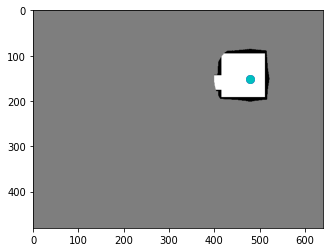

start
[479 151]
coll dx 15
coll dy 0
min_frontier_dist -78.5175139698144
paper reward 0.07157142857142858


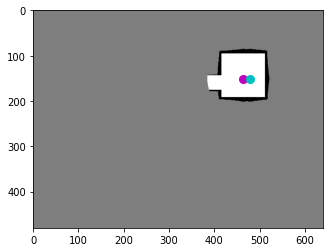

reward -0.8
robot loc [464 151]
False
coll dx 15
coll dy 0
min_frontier_dist -66.48308055437865
paper reward 0.07442857142857143


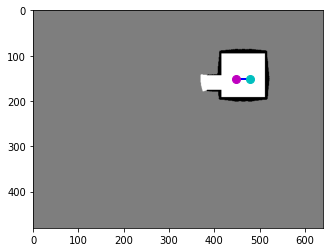

reward -0.8
robot loc [449 151]
False
coll dx 15
coll dy 0
min_frontier_dist -51.62363799656123
paper reward 0.09057142857142857


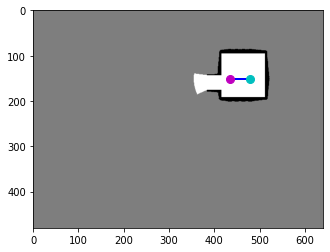

reward -0.8
robot loc [434 151]
False
coll dx 15
coll dy 0
min_frontier_dist -36.87817782917155
paper reward 0.1337142857142857


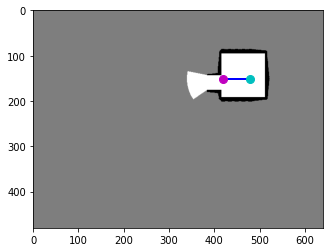

reward -0.8
robot loc [419 151]
False
coll dx 15
coll dy 0
min_frontier_dist -22.47220505424423
paper reward 0.22257142857142856


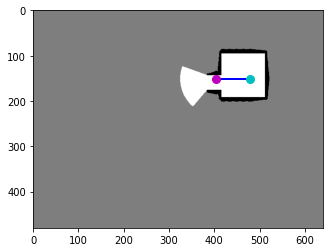

reward -0.8
robot loc [404 151]
False
coll dx 15
coll dy 0
min_frontier_dist -12.206555615733702
paper reward 0.4835714285714286


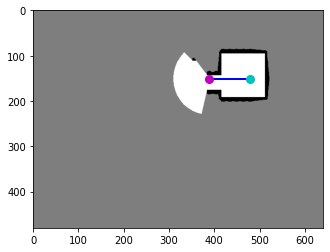

reward 0.3309894833747573
robot loc [389 151]
False
coll dx 15
coll dy 0
min_frontier_dist -48.373546489791295
paper reward 0.416


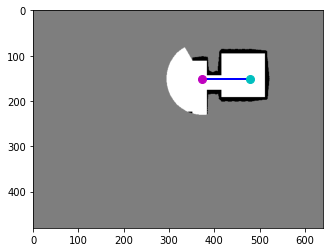

reward -0.8
robot loc [374 151]
False
coll dx 15
coll dy 0
min_frontier_dist -42.95346318982906
paper reward 0.313


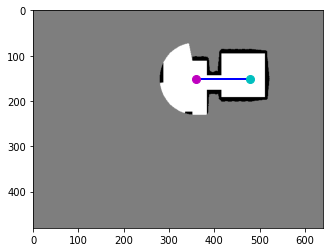

reward -0.8
robot loc [359 151]
False
coll dx 15
coll dy 0
min_frontier_dist -64.77653896280658
paper reward 0.2367142857142857


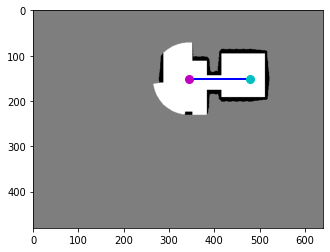

reward -0.8
robot loc [344 151]
False
coll dx 15
coll dy 0
min_frontier_dist -50.00999900019995
paper reward 0.1697142857142857


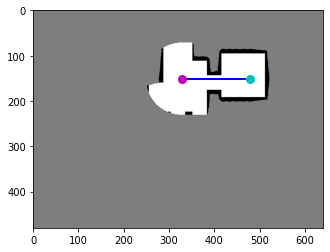

reward -0.8
robot loc [329 151]
False


In [69]:
import numpy as np
import random

np.random.seed(1000)
random.seed(10)

reward_func = FrontierRewardFunction(1 / 80)
action_space = PolarActionSpace(30)

robot = Robot(0, True, True, 'DRL_robot_exploration/DungeonMaps',action_space,reward_func, False)

test_action = np.array([0.75, 0.5])
print('start')
print(robot.robot_position)

for i in range(10):
  (map, loc), reward, terminal, complete, new_loc, collision, all_map = robot.step(test_action)
  print('reward', reward)
  print('robot loc', loc)
  print(collision)


In [2]:
import torch
import torch.nn as nn
import torchsummary
import numpy as np

def build_conv_feature_extractor(conv_dims, act):
  #Create Conv2D + MaxPool layers
  conv_layers = [nn.Conv2d(*conv_dim) if len(conv_dim) == 3 else nn.MaxPool2d(conv_dim) for conv_dim in conv_dims]
  total_layers = []

  #Add ReLU activations after each conv layer
  for layer in conv_layers:
    total_layers.append(layer)
    if type(layer) == nn.Conv2d:
      total_layers.append(act())
  return nn.Sequential(*total_layers)
  

def get_output_shape(model, image_dim):
    return model(torch.rand(*(image_dim))).data.shape

class RNNActor(nn.Module):
  #TODO Determine if the action space allows negative numbers
  #Potentially replace tanh with sigmoid
  def __init__(self, conv_dims, lstm_hidden, train_length, input_size=(1, 1,224,224), act=nn.ReLU, final_act=nn.Sigmoid):
    super(RNNActor, self).__init__()

    self.conv_mod = build_conv_feature_extractor(conv_dims, act)
    
    #Silly way to determine the size going into the RNN
    with torch.no_grad():
      feature_size = get_output_shape(self.conv_mod, input_size)

    print('LSTM Input Size', feature_size)

    #Construct LSTM
    self.lstm_hidden = lstm_hidden
    self.lstm_input = np.prod(list(feature_size)) + 2
    self.lstm = nn.LSTM(self.lstm_input, lstm_hidden)
    self.linear = nn.Linear(lstm_hidden, 2)
    self.train_length = train_length
    self.final_act = final_act()

  def forward(self, image, positions, hidden_state, lengths):
    batch_size = image.size()[1]
    conv = self.conv_mod(torch.reshape(image, (self.train_length * batch_size, 1, 224, 224)))
    print('COnv out', conv.size())

    flat = conv.view(-1).view(self.train_length, batch_size, self.lstm_input - 2)
    print("Flattened COnv Feats", flat.size())
    state = torch.cat((flat, positions), 2)
    print('Conv Feats w/ Position Size', state.size())
    packed = torch.nn.utils.rnn.pack_padded_sequence(state, lengths)
    states, final_state = self.lstm(packed, hidden_state)
    print('pre unpacking')
    unpacked,_ = torch.nn.utils.rnn.pad_packed_sequence(states)

    print('Unpacked Size', unpacked.size())

    final = self.linear(unpacked)
    return self.final_act(final), final_state

In [3]:
conv_dims = [(1, 32, 8), (32, 64, 4), (2, 2), (64, 64, 3), (64, 512, 7), (2, 2), (512, 64, 1)]

lstm_hidden = 512
lstm_out = 2
train_length = 8

rnn = RNNActor(conv_dims, lstm_hidden, train_length).to(device='cuda')

LSTM Input Size torch.Size([1, 64, 49, 49])


In [6]:
test_batch = torch.rand((train_length, 10, 1, 224, 224)).to(device='cuda')
test_positions = torch.rand((train_length, 15, 2)).to(device='cuda')
hidden = (torch.zeros((1, 10, 512)).to(device='cuda'), torch.zeros((1, 10, 512)).to(device='cuda'))
print(hidden[0].size())

test, _ = rnn(test_batch, test_positions, hidden, [train_length] * 15)
test.size()

torch.Size([1, 15, 512])
COnv out torch.Size([120, 64, 49, 49])
Flattened COnv Feats torch.Size([8, 15, 153664])
Conv Feats w/ Position Size torch.Size([8, 15, 153666])


RuntimeError: ignored

In [4]:
def build_dense_regression(linear_dims, act, final_act=None):
  linear_layers = [nn.Linear(*linear_dim)  for linear_dim in linear_dims]
  activations = [act() for layer in range(len(linear_layers) - 1)]
  if final_act is not None:
    activations.append(final_act)
  return nn.Sequential(*[val for tup in zip(*[linear_layers, activations]) for val in tup]
)

class CNNCritic(nn.Module):
  def __init__(self, conv_dims, fc_dims, input_size=(1, 1,224,224), conv_act=nn.ReLU, fc_act=nn.ReLU):
    super(CNNCritic, self).__init__()
    self.conv_mod = build_conv_feature_extractor(conv_dims, conv_act)

    #Silly way to determine the size going into the RNN
    with torch.no_grad():
      feature_size = get_output_shape(self.conv_mod, input_size)

    #Add 4 for action + position
    feature_size = np.prod(list(feature_size)) + 4
    first_output = fc_dims[0][0]
    fc_dims.insert(0, (feature_size, first_output))

    self.fc = build_dense_regression(fc_dims, fc_act)

    


  def forward(self, map, pos, action):
    batch_size = x.size()[0]
    map_feats = self.conv_mod(map)
    all_feats = torch.hstack([map_feats, pos, action])
    return self.fc(total_feats)

In [5]:
linear_dims = [(256, 128), (128, 1)]
conv_dims = [(1, 32, 8), (32, 64, 4), (2, 2), (64, 64, 3), (64, 512, 7), (2, 2), (512, 64, 1)]

critic = CNNCritic(conv_dims, linear_dims)

In [ ]:
""" Learn a policy using DDPG for the reach task"""
import numpy as np
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.nn import MSELoss
import random
import itertools

import gym
import pybullet
import pybulletgym.envs

import matplotlib.pyplot as plt
import copy

np.random.seed(1000)


# TODO: A function to soft update target networks
def weighSync(target_model, source_model, tau=0.001):
  for (target, src) in zip(target_model.parameters(), source_model.parameters()):
    target.data = (1-tau) * target.data + tau * src.data 

# TODO: Write the ReplayBuffer
class Replay():
    def __init__(self, buffer_size, init_episodes, max_episode_length, state_dim, action_dim, env):
        """
        A function to initialize the replay buffer.

        param: init_length : Initial number of transitions to collect
        param: state_dim : Size of the state space
        param: action_dim : Size of the action space
        param: env : gym environment object
        """
        self.buffer = [{}] * init_sequences
        self.sequence_length = sequence_length
        self.max_episode_length = max_episode_length
        self.env = env
        state = self.env.reset()
        self.buffer_idx = 0
        self.total_steps = 0
        last_state = env.reset()
        while self.buffer_idx < self.init_sequences:
          episode = self.generate_episode()
          sequences = self.episode_to_sequences(episode)
        init_policy = lambda map, pos: np.random.uniform(0, 1, (2,))
        for i in range(init_epsiodes):
          action = np.random.uniform(-1, 1, (2,))
          state, reward, _, _ = env.step(action)
          self.buffer[self.buffer_idx, :] = np.hstack([state, last_state, action, reward])
          self.total_steps = min(self.total_steps + 1, len(self.buffer))
          self.buffer_idx = (self.buffer_idx + 1) % len(self.buffer)
          last_state = state

    def generate_episode(self, policy):
      robot = Robot(0, True, True, 'DRL_robot_exploration/DungeonMaps',action_space,reward_func, False)
      episode = []
      last_map = torch.zeros((224, 224))
      last_position = torch.zeros((2, 1))
      terminal = False

      for i in range(self.max_episode_length):
        action = policy(last_map, last_position)
        (map, loc), reward, terminal, complete, new_loc, collision, all_map = robot.step(action.from_numpy())
        map_tensor = torch.tensor(map).float()
        position_tensor = torch.tensor(loc).float()
        reward_tensor = torch.tensor(reward).float()
        episode.append({'map': torch.tensor(map).float(), 'position': loc, 'reward': reward, 'action': action})
        last_map = map_tensor
        last_position = position_tensor
        if terminal:
          break


      self.buffer[self.buffer_idx] = {'episode':episode, 'length':length}
      self.buffer_idx = (self.buffer_idx + 1) % len(self.buffer)
      self.total_steps = min(self.total_steps + 1, len(self.buffer))


    '''
    def episode_to_sequences(self, episode):
      window = []
      sequences = []
      for i in range(self.sequence_length, len(episode)):
        if len(window) < self.sequence_length:
          window = deepcopy(window)
        else:
          window = window[1:]
        map_tensor = torch.cat([torch.unsqueeze(data['map'], 0) for data in window])
        position_tensor = torch.cat([torch.unsqueeze(data['position'], 0) for data in window])
        reward_tensor = torch.cat([torch.unsqueeze(data['position'], 0) for data in window])
        window.append(episode[i])
        sequences.append({'maps':torch.vstack())
      return sequences
    '''

    #TODO: Complete the function
    def buffer_sample(self, N):
        """
        A function to sample N points from the buffer
        param: N : Number of samples to obtain from the buffer
        """
        if N > self.total_steps:
          return torch.from_numpy(self.buffer[:self.total_steps, :]).float().to(device='cuda')

        samples = random.sample(self.buffer, N)
        return samples

    def batchify(self, samples):
      
      map_sequences = []
      position_sequences = []
      reward_sequences = []

      for sample in samples:
        episode = sample['episode']
        maps = []
        positions = []
        rewards = []
        for step in episode:
          maps.append(torch.unsqueeze(step['map'], 0))
          positions.append(torch.unsqueeze(step['position'], 0))
          rewards.append(torch.unsqueeze(step['reward'], 0))

        maps_sequence = torch.cat(maps, 0)
        positions_sequence = torch.cat(positions, 0)
        rewards_sequence = torch.cat(rewards, 0)

        map_sequences.append(map_sequence)
        position_sequences.append(position_sequence)
        reward_sequences.append(reward_sequence)

        lengths.append(sample['length'])

      return nn.utils.rnn.pad_sequence(map_sequences), nn.utils.rnn.pad_sequence(position_sequences), nn.utils.rnn.pad_sequence(rewared_sequences)

      


# TODO: Implement a DDPG class
class DDPG():
    def __init__(
            self,
            env,
            action_dim,
            state_dim,
            critic_lr=3e-4,
            actor_lr=3e-4,
            gamma=0.99,
            batch_size=100,
            seed=1000
    ):
        """
        param: env: An gym environment
        param: action_dim: Size of action space
        param: state_dim: Size of state space
        param: critic_lr: Learning rate of the critic
        param: actor_lr: Learning rate of the actor
        param: gamma: The discount factor
        param: batch_size: The batch size for training
        """
        np.random.seed(seed)
        torch.manual_seed(seed)
        self.gamma = gamma
        self.batch_size = batch_size
        self.env = env
        self.state_dim = state_dim

        # TODO: Create a actor and actor_target
        self.actor = Actor(state_dim, action_dim).to(device='cuda')
        self.actor_target = copy.deepcopy(self.actor)

        # TODO: Make sure that both networks have the same initial weights

        # TODO: Create a critic and critic_target object
        self.critic = Critic(state_dim, action_dim).to(device='cuda')
        self.critic_target = copy.deepcopy(self.critic)
        # TODO: Make sure that both networks have the same initial weights

        # TODO: Define the optimizer for the actor
        self.optimizer_actor = optim.Adam(self.actor.parameters(), actor_lr)
        # TODO: Define the optimizer for the critic
        self.optimizer_critic = optim.Adam(self.critic.parameters(), critic_lr)

        # TODO: define a replay buffer
        self.ReplayBuffer = Replay(10000, 1000, state_dim, action_dim, env)

    # TODO: Complete the function
    def update_target_networks(self):
        """
        A function to update the target networks
        """
        weighSync(self.actor_target, self.actor)
        weighSync(self.critic_target, self.critic)

    # TODO: Complete the function
    def update_network(self, y_i, obs, actions):
        """
        A function to update the function just once
        """
        qs = self.critic(obs, actions).squeeze(-1)
        critic_loss = self.critic_criterion(y_i, qs)
        critic_loss.backward()

        self.optimizer_critic.step()

        act = self.actor(obs)
        qs = self.critic(obs, act)
        #print(actions.size())
        (-qs).mean().backward()
        self.optimizer_actor.step()

  
    # TODO: Complete the function
    def train(self, num_steps):
        """
        Train the policy for the given number of iterations
        :param num_steps:The number of steps to train the policy for
        """
        self.critic_criterion = MSELoss()
        noise = MultivariateNormal(torch.zeros(2), torch.diag(torch.tensor([0.1, 0.1])))
        num_episodes = 0
        i = 0
        total_reward = 0
        total_steps = 0
        episode_reward = 0
        test_env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1')
        steps_list = []
        rewards = []
        while i < num_steps:
          done = False
          last_state = self.env.reset()
          num_episodes += 1
          while not done:
            i += 1
            self.optimizer_critic.zero_grad()
            self.optimizer_actor.zero_grad()

            action = self.actor(torch.from_numpy(last_state).float().to(device='cuda')) + noise.sample().to(device='cuda')
            state, reward, done, _ = self.env.step(action.cpu().detach().numpy())
            self.ReplayBuffer.buffer_add({'state':state, 'last_state':last_state, 'reward':reward, 'action':action})
            batch = self.ReplayBuffer.buffer_sample(self.batch_size)
            #print(batch.size())
            r_i = batch[:, -1]
            actions = batch[:,2*self.state_dim:2*self.state_dim+2]
            states = batch[:,self.state_dim:2*self.state_dim]
            next_states = batch[:, :self.state_dim]
            with torch.no_grad():
              crit = self.critic_target(next_states, self.actor_target(next_states)).squeeze(-1)
              y_i = r_i + self.gamma * crit

            self.update_network(y_i, states, actions)

            self.update_target_networks()

            if i % 100 == 0:
              test_done = False
              episode_reward = 0
              the_steps = 0
              s = test_env.reset()
              while not test_done:
                total_steps += 1
                the_steps += 1
                action = self.actor(torch.from_numpy(s).float().to(device='cuda')).detach().squeeze().cpu().numpy()
                n_state, r, test_done, _ = test_env.step(action)
                s = n_state
                episode_reward += r

              rewards.append(episode_reward)
              steps_list.append(the_steps)
              print('Episode reward')
              print(episode_reward)

            last_state = state

          state = self.env.reset()

        return rewards, steps_list